In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 🤖 Machine Learning

# ---- SUPERVISADA ---- #
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
import xgboost as xgboost
from sklearn.metrics import cohen_kappa_score
%matplotlib inline 
import warnings # ignore warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv(r'C:\Users\Darkos\Desktop\Labs\WEEK_6_Mid_project_ML\datasets\ozono.csv')
df_all_targets = pd.read_csv(r'C:\Users\Darkos\Desktop\Labs\WEEK_6_Mid_project_ML\datasets\df_all_targets.csv')
df_num = df.select_dtypes('number')
df_num.drop(columns=['año'],inplace=True)


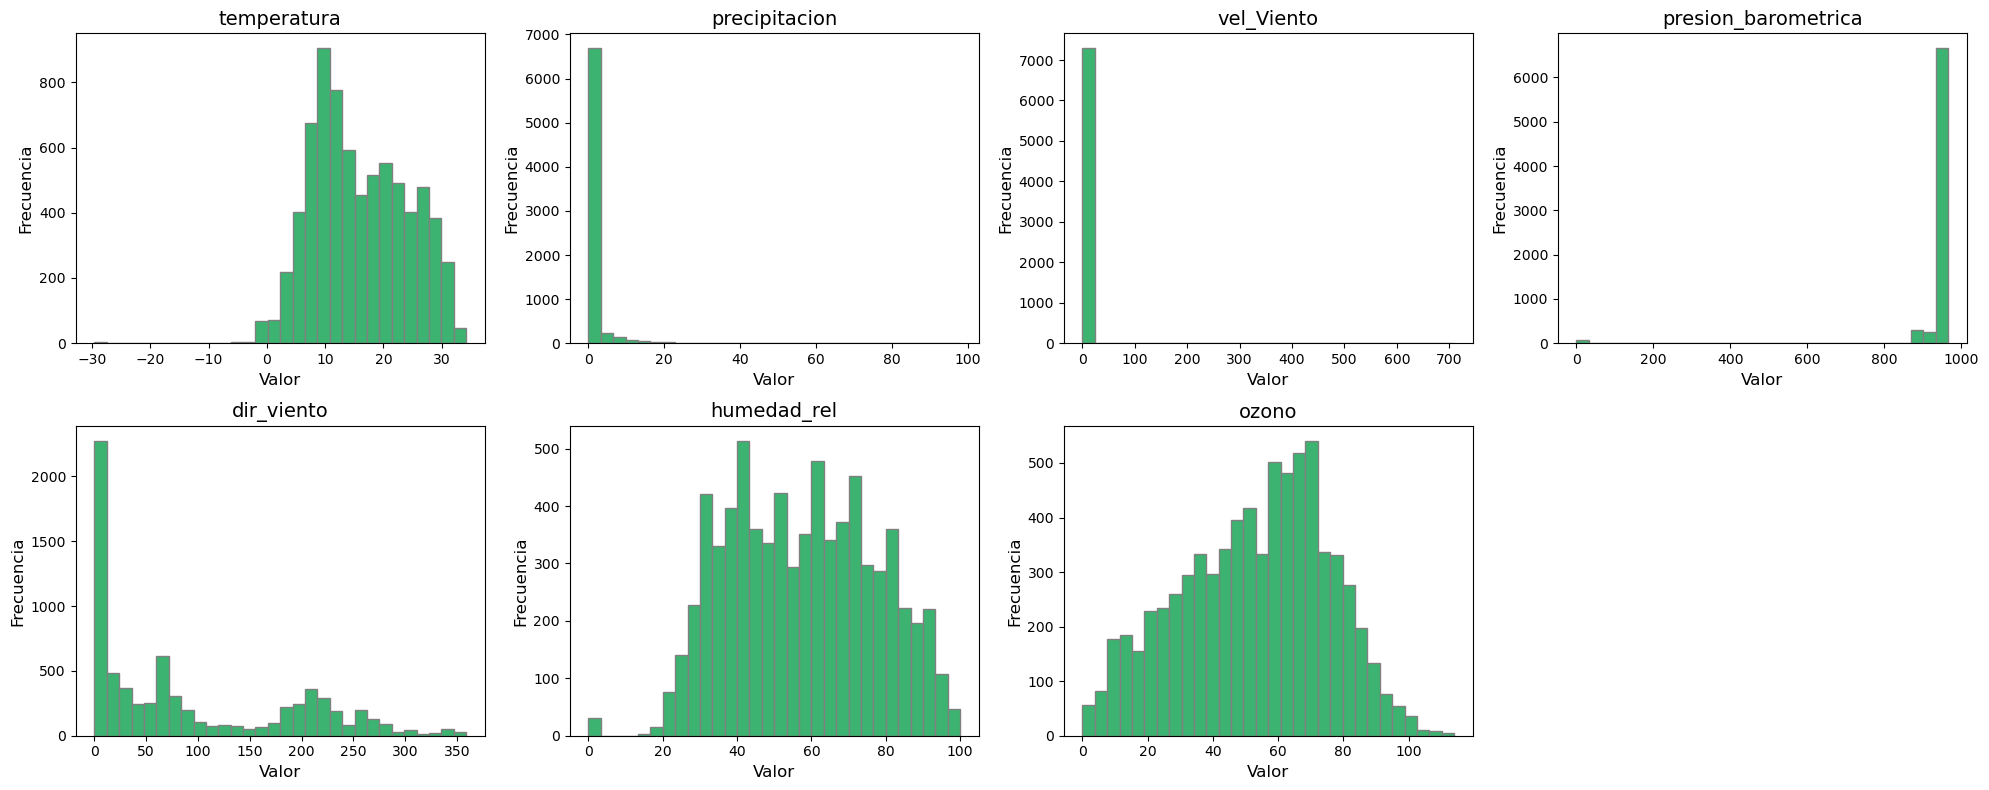

In [3]:
# Color para los histogramas
color = '#3CB371'

## selecciono las columnas que quiero plotear
columns_to_plot = ['temperatura', 'precipitacion', 'vel_Viento',
                   'presion_barometrica', 'dir_viento', 'humedad_rel', 'ozono']

## filtro el df que quiero con las columnas que quiero plotear en un nuevo df
df_selected = df_num[columns_to_plot] 

# Número de características numéricas seleccionadas
num_features = len(df_selected.columns)

# Ajustar dinámicamente el tamaño de la cuadrícula
ncols = 4  # Número fijo de columnas
nrows = int(np.ceil(num_features / ncols))  # Calcular filas según características

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))

# Aplanar los ejes para recorrerlos fácilmente, incluso si hay subtramas vacías
axes = axes.flatten()

# Graficar cada característica numérica seleccionada
for i, ax in enumerate(axes):
    if i < num_features:
        ax.hist(df_selected.iloc[:, i], bins=30, color=color, edgecolor='grey')
        ax.set_title(df_selected.columns[i], fontsize=14)
        ax.set_xlabel('Valor', fontsize=12)
        ax.set_ylabel('Frecuencia', fontsize=12)
    else:
        ax.axis('off')  # Ocultar subtramas vacías

# Ajustar el espaciado entre subtramas
plt.tight_layout()
plt.show()


<h2 style="color: #3CB371;">Checking Outliers</h2>

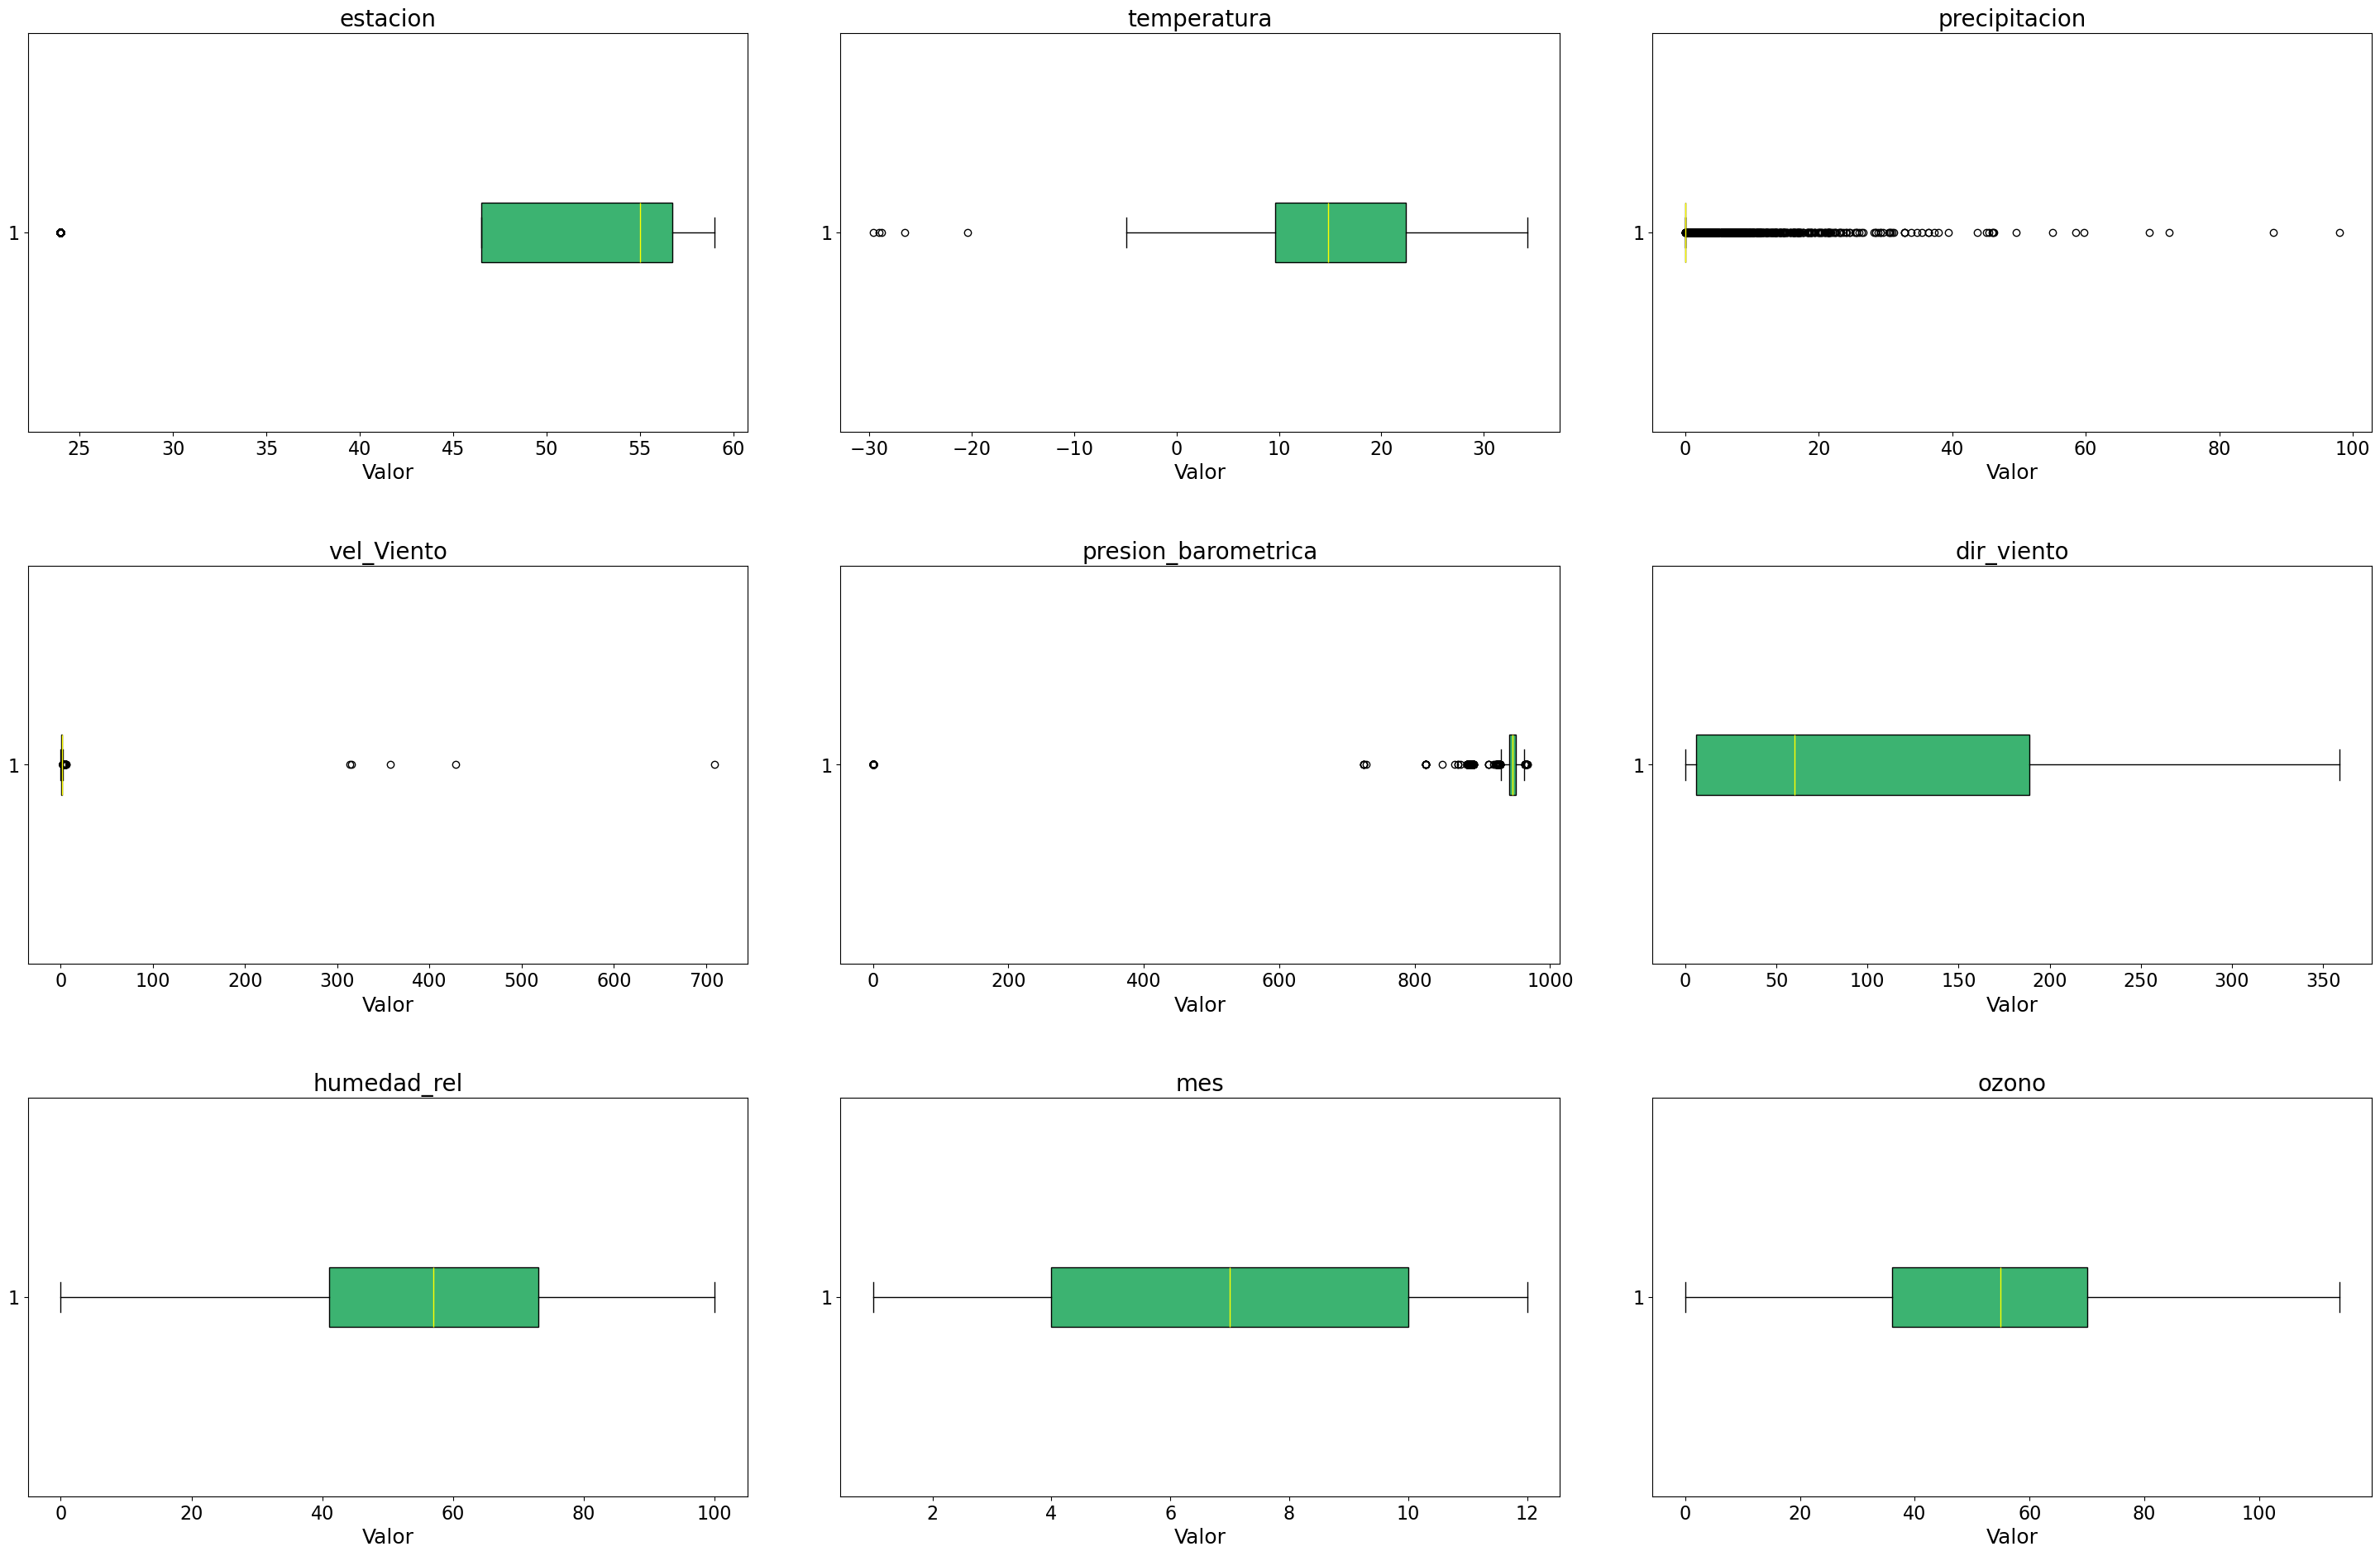

In [4]:
import matplotlib.pyplot as plt

# Color para los boxplots
color = '#3CB371'

# Tamaño de la cuadrícula
nrows, ncols = 3, 3  # Menos columnas para gráficos más grandes

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 20))  # Figura más grande

axes = axes.flatten()

# Graficar los boxplots
for i, ax in enumerate(axes):
    if i >= len(df_num.columns):
        ax.set_visible(False)  # Ocultar subtramas vacías
        continue
    ax.boxplot(df_num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow',), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=6))
    ax.set_title(df_num.columns[i], fontsize=20)  # Títulos más grandes
    ax.set_xlabel('Valor', fontsize=18)  # Etiqueta del eje X más grande
    ax.tick_params(axis='x', labelsize=16)  # Ticks más grandes
    ax.tick_params(axis='y', labelsize=16)  # Ticks más grandes

# Ajustar el espaciado entre subtramas
plt.tight_layout(pad=5.0)
plt.show()



<h2 style="color: #3CB371;"> CORRELACIONES </h2>

In [5]:
## DF CON TODAS LAS TARGETS MAS VARIABLES METEOROLOGICAS
df_all_targets_num = df_all_targets.select_dtypes('number')

df_all_targets_num.head()

,estacion,temperatura,precipitacion,vel_Viento,presion_barometrica,dir_viento,humedad_rel,mes,año,monoxido_nitrogeno,dioxido_nitrogeno,oxido_nitrogeno,ozono
0,24,4.40,0.00,0.69,957.00,22.00,67.00,1,2019,33.00,51.00,102.00,11.00
1,24,6.20,7.00,4.38,922.00,225.00,87.00,2,2019,1.00,3.00,5.00,77.00
2,24,11.10,0.00,1.14,951.00,53.00,53.00,3,2019,8.00,35.00,46.00,52.00
3,24,12.00,0.00,1.11,942.00,54.00,69.00,4,2019,4.00,26.00,32.00,53.00
4,24,18.50,0.00,1.33,940.00,267.00,41.00,5,2019,2.00,11.00,14.00,85.00


In [6]:
## VEO LA CORRELACION QUE TENGO DE LA TARGET OZONO CON CADA VARIABLE

# df_num.corrwith(df_num["ozono"]).sort_values(ascending=False)

In [7]:
df_all_targets_corr = round(df_all_targets_num.corr(),2)

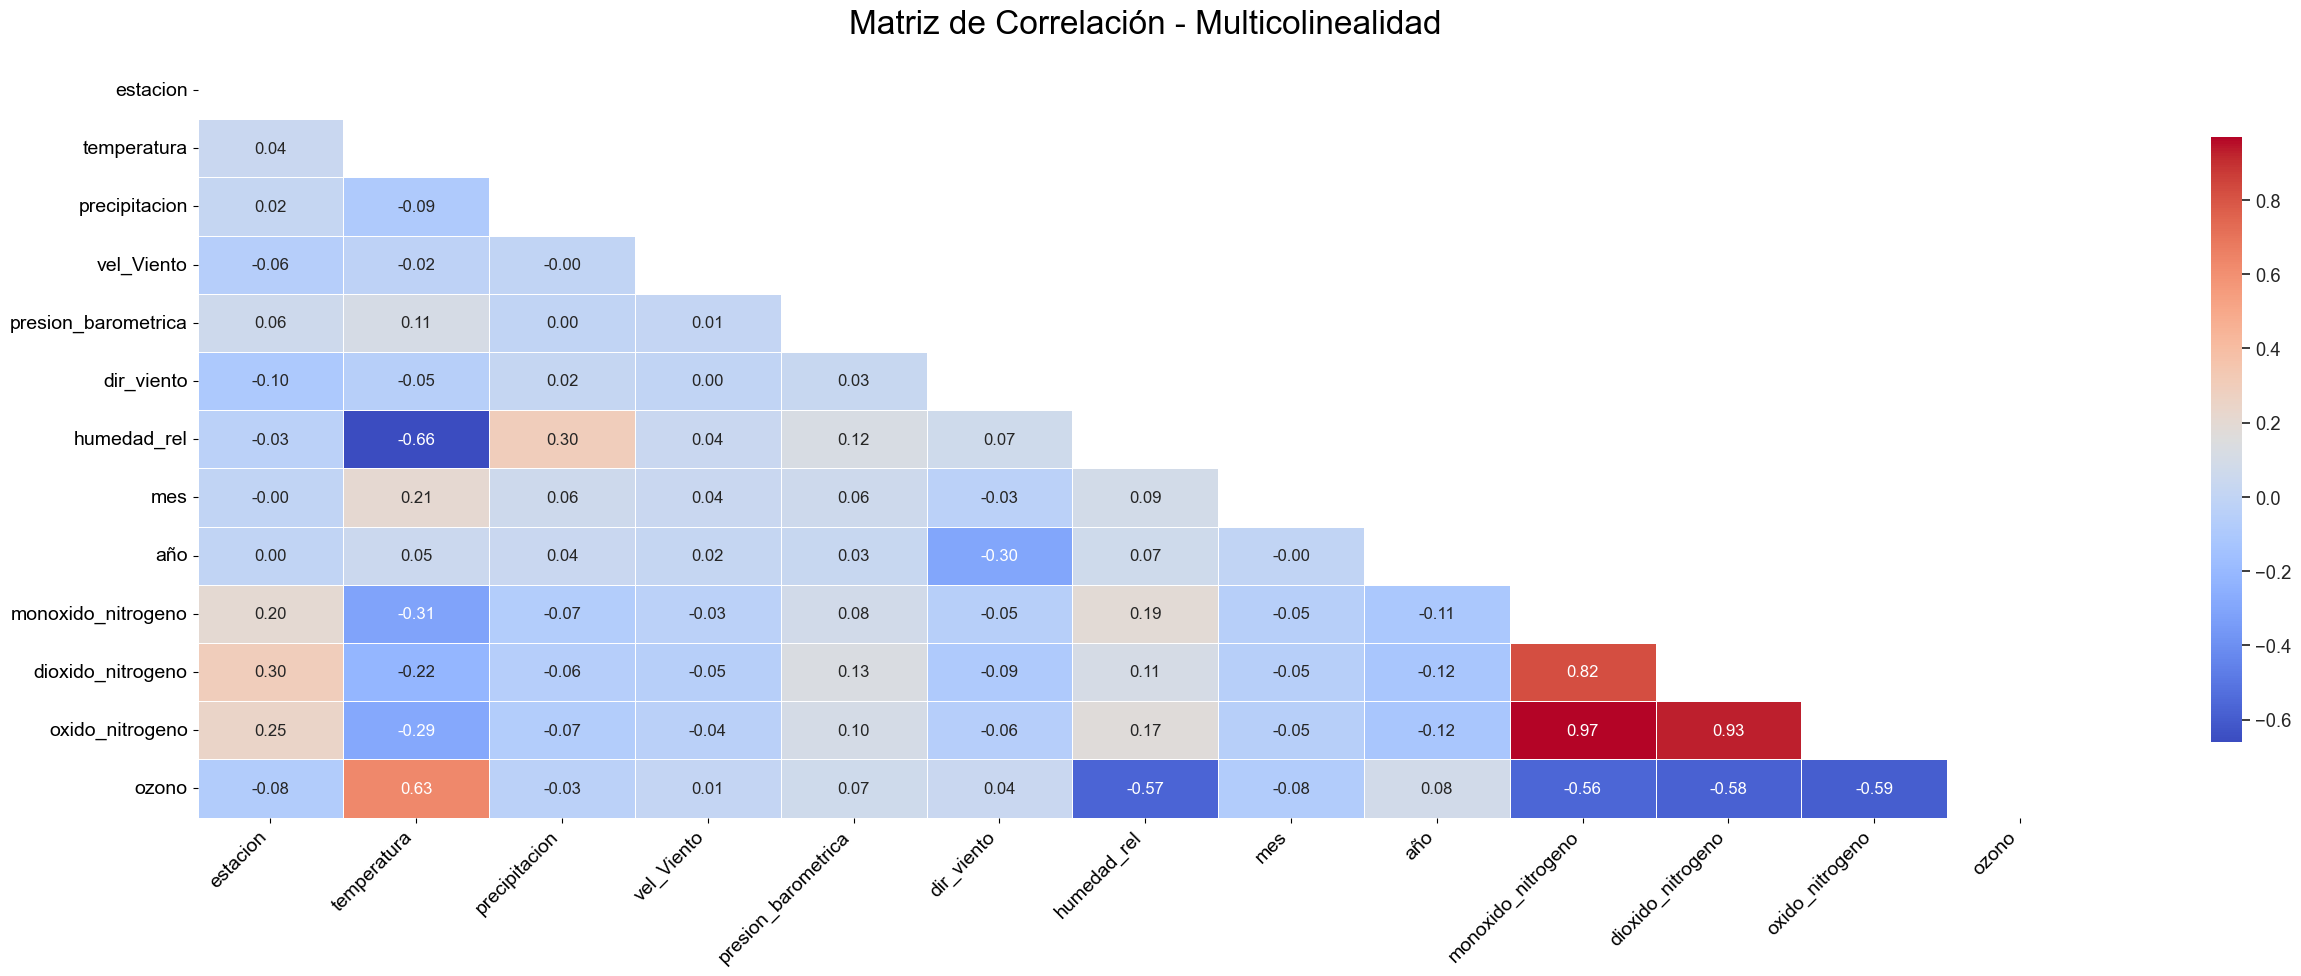

In [8]:
# Crear una máscara para ocultar la mitad superior de la matriz
mask = np.zeros_like(df_all_targets_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Ajustar el tamaño de la figura en función del número de columnas
fig_width = max(15, 2 * len(df_all_targets_corr.columns))  # Ajusta dinámicamente el ancho
fig_height = max(10, 0.5 * len(df_all_targets_corr.columns))  # Ajusta dinámicamente la altura

# Crear el gráfico
f, ax = plt.subplots(figsize=(fig_width, fig_height))

# Configuración de la paleta de colores y fuente
sns.set(font_scale=1.2)  # Tamaño general de fuente

heatmap = sns.heatmap(
    df_all_targets_corr, 
    mask=mask, 
    annot=True, 
    annot_kws={"size": 12},  # Tamaño de fuente de los valores
    linewidths=0.5, 
    cmap="coolwarm",  # Paleta de colores
    fmt=".2f", 
    cbar_kws={"shrink": 0.8},  # Tamaño de la barra de color
    ax=ax
)

# Título y ajustes de etiquetas
heatmap.set_title("Matriz de Correlación - Multicolinealidad", fontsize=24, pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


<h2 style="color: #3CB371;">X-y split & Train-test split</h2>

In [9]:
X = df_num.drop(columns='ozono',axis=1)
y = df['ozono']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

print(f'100% of our data: {len(df)}.')
print(f'70% for training data: {len(X_train)}.')
print(f'30% for test data: {len(X_test)}.')

100% of our data: 7300.
70% for training data: 5840.
30% for test data: 1460.


In [34]:
## LAZY PREDICT

# Crear el objeto LazyRegressor
regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Entrenar y evaluar los modelos
models, predictions = regressor.fit(X_train, X_test, y_train, y_test)

# Mostrar los resultados ordenados por R²
print(models.head(10))  # Muestra los 10 mejores modelos

 98%|█████████▊| 41/42 [00:14<00:00,  3.69it/s]  File "c:\Users\Darkos\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Darkos\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Darkos\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Darkos\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
100%|██████████| 42/42 [00:14<00:00,  2.99it/s]

                            Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                      
ExtraTreesRegressor                       0.80       0.80 13.04        1.47
XGBRegressor                              0.78       0.78 13.57        0.58
RandomForestRegressor                     0.78       0.78 13.62        1.95
BaggingRegressor                          0.76       0.76 14.27        0.23
MLPRegressor                              0.61       0.61 18.44        3.03
DecisionTreeRegressor                     0.60       0.60 18.24        0.03
ExtraTreeRegressor                        0.57       0.57 18.97        0.03
KNeighborsRegressor                       0.54       0.55 19.94        0.13
TransformedTargetRegressor                0.25       0.26 25.45        0.02
LinearRegression                          0.25       0.26 25.45        0.02


In [11]:
## TEST CON EXTRA_TREES_REGRESSOR

# Crear el modelo ExtraTreesRegressor
etr = ExtraTreesRegressor(random_state=42)
etr.fit(X_train, y_train)

## predict
y_pred_extra_trees = etr.predict(X_test)

## metricas
mse = mean_squared_error(y_test, y_pred_extra_trees)
r2 = r2_score(y_test, y_pred_extra_trees)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Mean Squared Error: 98.94
R^2 Score: 0.81


In [12]:
## TEST CON NORMALIZACION MIN_MAX_SCALER

scaler = MinMaxScaler()

## scaled
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

## predict
predictions_RFR = model.predict(X_test_scaled)

## metricas
r2_3_7 = r2_score(y_test, predictions_RFR)
RMSE_3_7 = mean_squared_error(y_test, predictions_RFR, squared=False)
MSE_3_7 = mean_squared_error(y_test, predictions_RFR)
MAE_3_7 = mean_absolute_error(y_test, predictions_RFR)

print("R2 = ", round(r2_3_7, 4))
print("RMSE = ", round(RMSE_3_7, 4))
print("The value of the metric MSE is ", round(MSE_3_7, 4))
print("MAE = ", round(MAE_3_7, 4))

R2 =  -5.5233
RMSE =  57.5601
The value of the metric MSE is  3313.1619
MAE =  52.9647


In [13]:
## TEST CON NORMALIZACION MIN_MAX_SCALER

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, y_train)
predictions_RFR_Scaled = model.predict(X_test_scaled)
r2_3_7 = r2_score(y_test, predictions_RFR_Scaled)
RMSE_3_7 = mean_squared_error(y_test, predictions_RFR_Scaled, squared=False)
MSE_3_7 = mean_squared_error(y_test, predictions_RFR_Scaled)
MAE_3_7 = mean_absolute_error(y_test, predictions_RFR_Scaled)

print("R2 = ", round(r2_3_7, 4))
print(1-(1-r2_3_7)*((len(X_test_scaled)-1)/(len(X_test_scaled)-len(X_test_scaled[0])-1)))
print("RMSE = ", round(RMSE_3_7, 4))
print("The value of the metric MSE is ", round(MSE_3_7, 4))
print("MAE = ", round(MAE_3_7, 4))

R2 =  0.798
0.7968373362702676
RMSE =  10.1302
The value of the metric MSE is  102.6206
MAE =  7.8019


<h1 style="color: #3CB371;">T E S T </h1>

In [14]:
df_all_targets_num = df_all_targets.select_dtypes('number')
df_all_targets_num.columns

Index(['estacion', 'temperatura', 'precipitacion', 'vel_Viento',
       'presion_barometrica', 'dir_viento', 'humedad_rel', 'mes', 'año',
       'monoxido_nitrogeno', 'dioxido_nitrogeno', 'oxido_nitrogeno', 'ozono'],
      dtype='object')

In [15]:
## X_Y TRAIN - X_Y TEST

## seleccionar múltiples targets
y = df_all_targets_num[['monoxido_nitrogeno', 'dioxido_nitrogeno', 'oxido_nitrogeno', 'ozono']]  ## lista para seleccionar columnas

## crear el conjunto de características (X) sin cambiar
X = df_all_targets_num.drop(columns=['monoxido_nitrogeno', 'dioxido_nitrogeno', 'oxido_nitrogeno', 'ozono'], axis=1)

## train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## print tamaño de los conjuntos
print(f'100% of our data: {len(df_all_targets_num)}.')
print(f'80% for training data: {len(X_train)}.')
print(f'20% for test data: {len(X_test)}.')



100% of our data: 7300.
80% for training data: 5840.
20% for test data: 1460.


In [ ]:
## EVALUACION CON EXTRA_TREES_REGRESSOR HACIENDO ANALISIS MULTITARGET

results = [] ## me creo un dic para almacenar los resultados y poder crear un DF

for column in y_train.columns:
    print(f"Target: {column}")
       
	## entreno un modelo independiente para cada target
    etr = ExtraTreesRegressor(random_state=42)
    etr.fit(X_train, y_train[column]) 
    
    ## predict
    y_pred = etr.predict(X_test)
    
    ## metricas
    mse = mean_squared_error(y_test[column], y_pred)
    r2 = r2_score(y_test[column], y_pred)
    
    ## R^2 ajustado
    n = len(X_test)
    p = X_test.shape[1]  
    r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # resultados
    print(f"Mean Squared Error: {mse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print(f"R^2 Adjusted Score: {r2_adjusted:.3f}")
    print()
    
    result = {'target': column, 'r2': r2}
    
    ## importancia de características
    print("Feature Importances:")
    feature_importances = etr.feature_importances_
    for name, importance in zip(X_train.columns, feature_importances):
        print(f"Feature: {name}, importance: {importance:.3f}")
        result[f'importance_{name}'] = importance
        
    results.append(result)
            
	## Una mayor importancia indica que una característica se usó con más frecuencia y tuvo un mayor impacto al reducir la incertidumbre en las predicciones

    print('-' * 40)
    
results_df = pd.DataFrame(results)


In [ ]:
results_df.reset_index(drop=True,inplace=True)

In [33]:
df_importance = results_df.set_index('target').T
df_importance.to_csv(r'C:\Users\Darkos\Desktop\Labs\WEEK_6_Mid_project_ML\df_importance.csv')


<h1 style="color: #3CB371;">T E S T _ 2  (sin precipitacion) </h1>

In [17]:
df_all_targets_num.drop(columns='dir_viento', inplace=True)

In [18]:
y = df_all_targets_num[['monoxido_nitrogeno', 'dioxido_nitrogeno', 'oxido_nitrogeno', 'ozono']] 

X = df_all_targets_num.drop(columns=['monoxido_nitrogeno', 'dioxido_nitrogeno', 'oxido_nitrogeno', 'ozono'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'100% of our data: {len(df_all_targets_num)}.')
print(f'80% for training data: {len(X_train)}.')
print(f'20% for test data: {len(X_test)}.')

100% of our data: 7300.
80% for training data: 5840.
20% for test data: 1460.


In [19]:
## EVALUACION CON EXTRA_TREES_REGRESSOR HACIENDO ANALISIS MULTITARGET

## TEST 2 (SIN PRECIPITACION)

for column in y_train.columns:
    print(f"Target: {column}")
    
    etr = ExtraTreesRegressor(random_state=42)
    etr.fit(X_train, y_train[column]) 
    
    y_pred = etr.predict(X_test)
    
    mse = mean_squared_error(y_test[column], y_pred)
    r2 = r2_score(y_test[column], y_pred)
    
    n = len(X_test)
    p = X_test.shape[1]  
    r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    print(f"Mean Squared Error: {mse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print(f"R^2 Adjusted Score: {r2_adjusted:.3f}")
    print()
    
    print("Feature Importances:")
    feature_importances = etr.feature_importances_
    for name, importance in zip(X_train.columns, feature_importances):
        print(f"Feature: {name}, importance: {importance:.3f}")

    print('-' * 40)


Target: monoxido_nitrogeno
Mean Squared Error: 97.147
R^2 Score: 0.746
R^2 Adjusted Score: 0.744

Feature Importances:
Feature: estacion, importance: 0.205
Feature: temperatura, importance: 0.117
Feature: precipitacion, importance: 0.018
Feature: vel_Viento, importance: 0.257
Feature: presion_barometrica, importance: 0.099
Feature: humedad_rel, importance: 0.061
Feature: mes, importance: 0.141
Feature: año, importance: 0.102
----------------------------------------
Target: dioxido_nitrogeno
Mean Squared Error: 61.892
R^2 Score: 0.817
R^2 Adjusted Score: 0.816

Feature Importances:
Feature: estacion, importance: 0.265
Feature: temperatura, importance: 0.079
Feature: precipitacion, importance: 0.018
Feature: vel_Viento, importance: 0.280
Feature: presion_barometrica, importance: 0.082
Feature: humedad_rel, importance: 0.053
Feature: mes, importance: 0.132
Feature: año, importance: 0.091
----------------------------------------
Target: oxido_nitrogeno
Mean Squared Error: 448.332
R^2 Score

<h4 style="color: #3CB371;">El modelo no mejora quitando las variables de precipitacion y direccion de viento </h4>